# Closed competitive - log Utility

type some text

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import newton

## Parameters

### Consumers

| parameter | description                                    |
|-----------|------------------------------------------------|
| N         | population                                     |
| W         | wages at the centre                            |
| t         | marginal cost of primary commute               |
| t_        | fixed cost of alternative commute              |
| θ         | job centralisation weight                      |
| a         | coefficient for log utility of housing, H      |


In [21]:
N = 1
W = 5
t = 2.5
t_ = 0
theta = 0.2
a = 1

### Developers

| parameter | description                                    |
|-----------|------------------------------------------------|
| r_        | land rent at the urban/rural boundary          |
| δ         | cost elasticity of building height             |
| c0        | cost scalar for building height                | 


In [22]:
r_ = 1
delta = 1.6
c0 = 1

### Landlords

| parameter | description                                    |
|-----------|------------------------------------------------|
| t_I       | marginal tax rate for rental income            |
| t_CG      | marginal tax rate for capital gains income     |
| t_ID      | rate of tax deductibility                      |
| t_R       | average tax rate for local government          |
| f         | maintenance costs of housing                   |
| β         | share of debt financing vs equity              |
| π         | general price inflation (nominal)              |
| g         | house price inflation net of general inflation |
| i         | interest rate on borrowing                     |
| φ         | equity risk prem                               |


In [23]:
t_I = 0.33
t_CG = 0.15
t_ID = t_I
t_R = 0.0033
f = 0.01
beta = 0.5
pi = 0.015
g = 0.015
i = 0.045
phi = 0.03

## Derived parameters
The Poterba scaler:

In [24]:
j = ((beta * i + f + t_R) * (1 - t_ID) + (1 - beta) * (i + phi) - (g + pi) * (1 - t_CG)) / (1 - t_I)

In [25]:
B = -theta * t * delta / (a * (delta - 1))
A = lambda d_: 2 * np.pi / a * delta * j * r_ / (delta - 1) * np.exp(-B * d_)


## Solve for equilibrium city radius


In [26]:
city_radius_eqn = lambda d_: A(d_) / B * (d_ * np.exp(B * d_) - (np.exp(B * d_) - 1) / B) - N
d_ = newton(city_radius_eqn, 1)

## Solve initial condition for rent at the centre

In [27]:
p0 = delta * c0 ** (1 / delta) * j * (r_ / (delta - 1)) ** ((delta - 1) / delta) * np.exp(theta * t * d_ / a)


## Equilibrium prices/quantities

### Rent and house prices


In [28]:
p = lambda d: p0 * np.exp(-theta * t * d / a)
P = lambda d: p(d) / j



### Land prices


In [29]:
r = lambda d: r_ * np.exp(-B * (d_ - d))



### Land quantity


In [30]:
L = lambda d: a * (delta * c0 * j) ** (1 / (delta - 1)) * p(d) ** (delta / (1 - delta))
L_density = lambda d: 1 / L(d)

### Housing quantity

In [31]:
H = lambda d: a / p(d)
h = lambda d: H(d) / L(d)


### Utility

In [32]:
U = W - (1 - theta) * t_ - a + a * np.log(a) - a * np.log(p0)

### Differential land rents

In [33]:
diff_land_rents, error = quad(lambda d: 2 * np.pi * d * (r(d) - r_), 0, d_)


## Calculate prices/quantities at a range of distances from the city centre

In [34]:
d = np.linspace(0, 1.5, 301)

eq = pd.DataFrame({'p(d)': p(d),
                   'P(d)': P(d),
                   'r(d)': r(d),
                   'L(d)': L(d),
                   '1/L(d)': L_density(d),
                   'H(d)': H(d),
                   'h(d)': h(d),
                   'r_': r_})
eq.index = d



## Price and rent plot


In [ ]:
eq['r(d)'].plot(label='Land price')
eq['P(d)'].plot(label='House price')
eq['r_'].plot(label='Farm land price')
eq['p(d)'].plot(label='House rents', c='gold')
plt.legend()
plt.show()

## Check against original

In [36]:
original = pd.read_csv('../original/output/original_output.csv', index_col=0)

# check that the original and new solutions are the same
assert np.allclose(original, eq)

## New symmetrical plot

In [46]:
# create a plot like the above but symmetric about d = 0 to represent the cross-section of a city

# first, take the required columns from the dataframe except the first row, and reverse the order
# then, append the original dataframe to the reversed dataframe

# taking the r(d) P(d), r_ and p(d) columns, and renaming them 'Land price', House price', 'Farm land price', and 'House rents'

negatives = eq[['r(d)', 'P(d)', 'r_', 'p(d)']].iloc[1:].iloc[::-1]
negatives.index = -negatives.index
symmetric = pd.concat([negatives, eq[['r(d)', 'P(d)', 'r_', 'p(d)']]], axis=0)
symmetric.columns = ['Land price', 'House price', 'Rural land price', 'House rents']


C:\Users\DavisC\AppData\Local\Temp\ipykernel_6404\3076737999.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


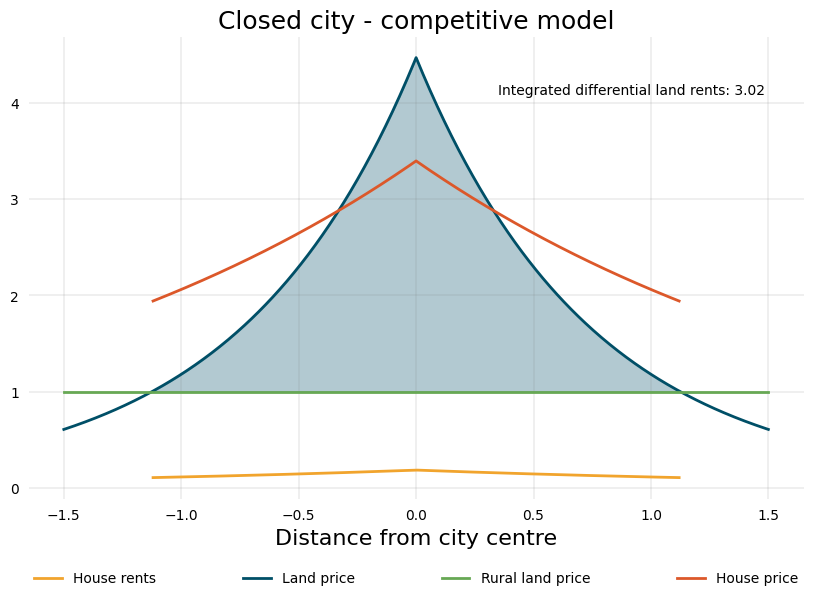

In [93]:
# plot the houe rents in gold, land price in blue, the rural land price in green and the house price in orange
# shade the area between the house price and the rural land price in blue with 30% transparency

# define colours

GOLD = np.array((241, 164, 45))/255
BLUE = np.array((0, 79, 103))/255
GREEN = np.array((103, 168, 84))/255
ORANGE = np.array((220,88,42))/255

LINEWIDTH = 2

fig = plt.figure(figsize=(10, 6))
plt.plot(symmetric['House rents'].loc[abs(symmetric.index) <= d_], label = 'House rents', color=GOLD, linewidth=LINEWIDTH)
plt.plot(symmetric['Land price'], label = 'Land price', color=BLUE, linewidth=LINEWIDTH)
plt.plot(symmetric['Rural land price'], label = 'Rural land price', color=GREEN, linewidth=LINEWIDTH)
plt.plot(symmetric['House price'].loc[abs(symmetric.index) <= d_], label = 'House price', color=ORANGE, linewidth=LINEWIDTH)
# put the legend outside the plot, horizontally at the bottom
plt.legend(bbox_to_anchor=(0., -0.2, 1., .102), loc='lower left',
              ncol=4, mode="expand", borderaxespad=0., frameon=False)
# shade the area between the house price and the rural land price in blue with 30% transparency
plt.fill_between(symmetric.index[abs(symmetric.index) <= d_], symmetric['Land price'].loc[abs(symmetric.index) <= d_], 
                    symmetric['Rural land price'].loc[abs(symmetric.index) <= d_], color=BLUE, alpha=0.3)

# annotate the plot with the integrated differential land rents near the top right corner
plt.annotate('Integrated differential land rents: {:.2f}'.format(diff_land_rents), 
    xy=(0.95, 0.9), xycoords='axes fraction', fontsize=10,
    horizontalalignment='right', verticalalignment='top')

# format plot in the tufte style using matplotlib
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# make tick marks invisible
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)

#draw very faint grid lines

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.7)

plt.gca().set_xlabel('Distance from city centre', fontsize=16)
plt.gca().set_title('Closed city - competitive model', fontsize=18)
fig.show()
fig.savefig('closed_competitive_log_U.png', dpi=300, bbox_inches='tight')
